In [35]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as P
import scipy.ndimage as ndimage
import tifffile as tf
import pandas as pd
import glob
import os
import importlib
%matplotlib inline

In [2]:
import amaizeing_utils as maize
importlib.reload(maize)

<module 'amaizeing_utils' from '/home/ejam/documents/css893/imagening_amaizeing/code/amaizeing_utils.py'>

In [3]:
# Path to the split leaves (greyscale TIFFs)
lsrc = '/home/ejam/documents/css893/foo/'

# Path to the scaned leaves (original colored JPGs)
ssrc = '/home/ejam/documents/css893/leaves2018/'

# Path to save the colored masks
dst = '/home/ejam/documents/css893/perimeter/'

Bname = []
Perimeter = []
Area = []
Ratio = []

R_coeff2_2 = []
R_coeff2_1 = []
R_coeff2_0 = []

R_coeff3_3 = []
R_coeff3_2 = []
R_coeff3_1 = []
R_coeff3_0 = []

L_coeff2_2 = []
L_coeff2_1 = []
L_coeff2_0 = []

L_coeff3_3 = []
L_coeff3_2 = []
L_coeff3_1 = []
L_coeff3_0 = []

R_length2 = []
R_length3 = []

L_length2 = []
L_length3 = []

Length2 = []
Length3 = []

border = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])
cutoff = 0.1
tiffs = sorted(glob.glob(lsrc + '*.tif'))
leftover = 0
write=True

In [364]:
#tiff_file = lsrc + 'IMAG0024_l0_x1373_y1953.tif'
#tiff_file = lsrc + 'IMAG0043_l0_x955_y2498.tif'
tiff_file = lsrc + 'IMAG0056_l1_x1368_y610.tif'
#tiff_file = lsrc + 'IMAG0065_l1_x1259_y1339.tif'
#tiff_file = lsrc + 'IMAG0715_l0_x864_y473.tif'

raw, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]
sname = bname.split('_')[0]
print(bname)

img = tf.imread(tiff_file)
img[img > 0] = 1

if img.shape[0] > img.shape[1]:
    img = img.T
img.shape

IMAG0056_l1_x1368_y610


(852, 7016)

In [365]:
margin = maize.get_margin(img, border)

(852, 7016)

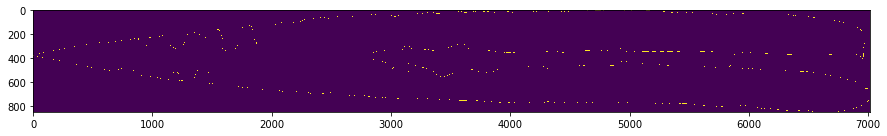

In [366]:
plt.figure(figsize=(15,3))
plt.imshow(margin)
margin.shape

Text(0.5, 1.0, '(245, 2)')

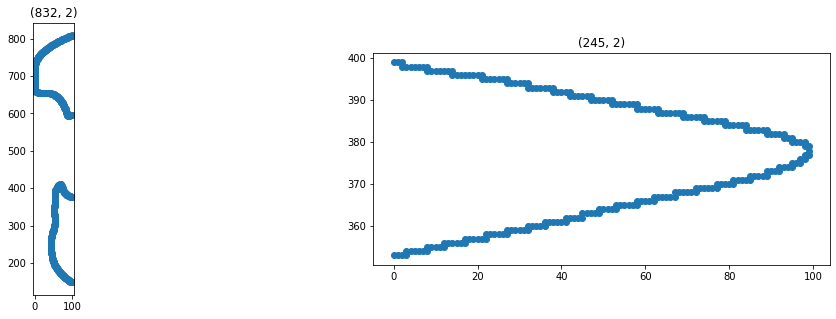

In [368]:
margin, base, tip = maize.orient_base2tip(margin)

fig,axis = plt.subplots(1,2,figsize=(18,5))

axis[0].plot(base[:,1], base[:,0], 'o')
axis[0].set_aspect('equal')
axis[0].set_title(base.shape)

axis[1].plot(tip[:,1], tip[:,0], 'o')
axis[1].set_aspect('equal')
axis[1].set_title(tip.shape)

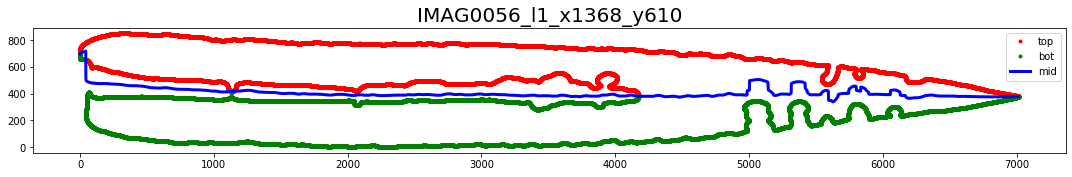

In [373]:
importlib.reload(maize)
midrib = maize.get_midrib(margin)
blades = maize.split_margin(margin, midrib)

plt.figure(figsize=(15,5))
plt.plot(blades[0][:,0], blades[0][:,1], '.', c='r', label='top')
plt.plot(blades[1][:,0], blades[1][:,1], '.', c='g', label='bot')
plt.plot(midrib[:,0], midrib[:,1], c='b', lw=3, label='mid')

plt.axis('scaled')
plt.legend()
plt.title(bname, fontsize=20)
plt.tight_layout()

In [378]:
coords = np.vstack(blades)
np.mean(coords,axis=0)

array([3168.67579511,  404.93955738])

In [379]:
importlib.reload(maize)
#tiff_file = lsrc + 'IMAG0024_l0_x1373_y1953.tif'
#tiff_file = lsrc + 'IMAG0043_l0_x955_y2498.tif'
tiff_file = lsrc + 'IMAG0056_l1_x1368_y610.tif'
#tiff_file = lsrc + 'IMAG0065_l1_x1259_y1339.tif'
#tiff_file = lsrc + 'IMAG0715_l0_x864_y473.tif'

raw, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

img = tf.imread(tiff_file)
blades = maize.top_bot_blade(img, border)

for i in range(3):
    blades[i] = np.add(blades[i], -1*blades[-1])

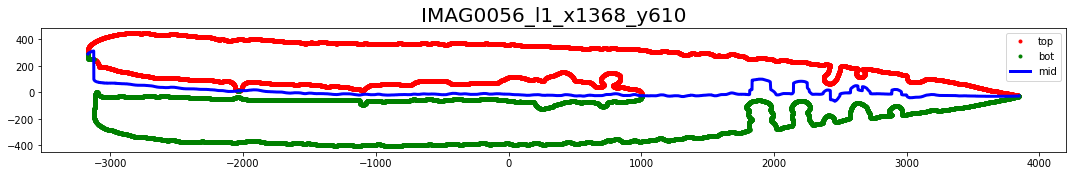

In [381]:
plt.figure(figsize=(15,5))
plt.plot(blades[0][:,0], blades[0][:,1], '.', c='r', label='top')
plt.plot(blades[1][:,0], blades[1][:,1], '.', c='g', label='bot')
plt.plot(blades[2][:,0], blades[2][:,1], lw=3, c='b', label='mid')

plt.axis('scaled')
plt.legend()
plt.title(bname, fontsize=20)
plt.tight_layout()

In [396]:
for i in range(2):
    blades[i] = maize.refine_margin(blades[i])

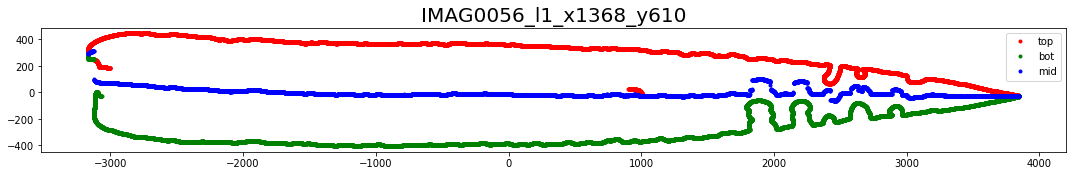

In [394]:
importlib.reload(maize)

plt.figure(figsize=(15,5))
plt.plot(maize.refine_margin(blades[0])[:,0], maize.refine_margin(blades[0])[:,1], '.', c='r', label='top')
plt.plot(maize.refine_margin(blades[1])[:,0], maize.refine_margin(blades[1])[:,1], '.', c='g', label='bot')
plt.plot(blades[2][:,0], blades[2][:,1], '.', c='b', label='mid')

plt.axis('scaled')
plt.legend()
plt.title(bname, fontsize=20)
plt.tight_layout()

(-3431.225795114483, 4192.874204885517, -459.4679922463421, 489.1808442798077)

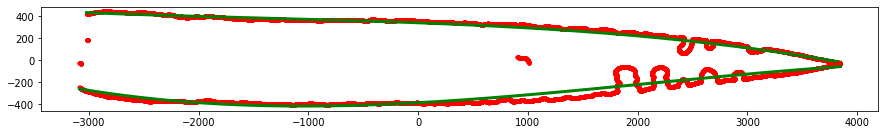

In [397]:
leftover = 0.05
skip = int(leftover*blades[0].shape[0])

coef = [None for x in range(len(blades))]
rang = [None for x in range(len(blades))]
pred = [None for x in range(len(blades))]
plt.figure(figsize=(15,5))

for i in range(2):
    coef[i], rang[i], pred[i] = maize.curve_fitting(blades[i], 3, skip)
    plt.plot(blades[i][skip:,0], blades[i][skip:,1], '.r')
    plt.plot(rang[i], pred[i], 'g', lw=3)

plt.axis('scaled')

(-3176.075795114483,
 -3013.2757951144827,
 -280.23955738047187,
 452.36044261952816)

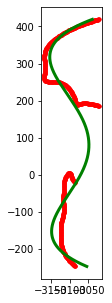

In [398]:
base = np.flip(np.vstack((blades[0][:skip,],blades[1][:skip,])), 1)
c,r,p = maize.curve_fitting(base, 4)

plt.figure(figsize=(15,5))
plt.plot(base[:,1], base[:,0], '.r')
plt.plot(p,r,'g', lw=3)
plt.axis('scaled')

(-3503.6564458143466,
 4196.312807458289,
 -458.90980732408747,
 477.4589609124605)

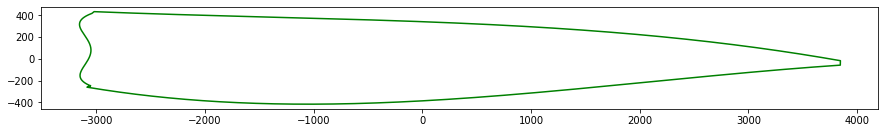

In [399]:
margin = np.vstack((np.dstack((p,r)).squeeze(),
                    np.dstack((rang[0], pred[0])).squeeze(),
                    np.flip(np.dstack((rang[1], pred[1])).squeeze(), axis=0),
                    np.array([p[0],r[0]])))

plt.figure(figsize=(15,5))
plt.plot(margin[:,0], margin[:,1], '-g')
plt.axis('scaled')

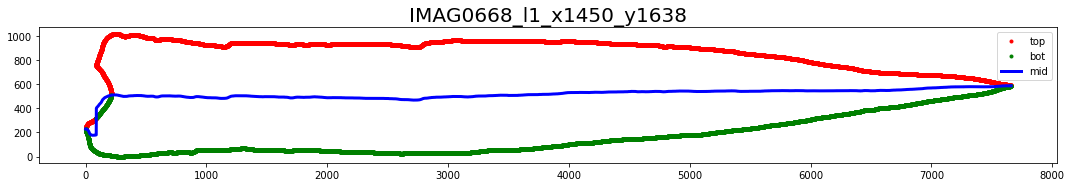

In [48]:
importlib.reload(maize)
#tiff_file = lsrc + 'IMAG0024_l0_x1373_y1953.tif'
#tiff_file = lsrc + 'IMAG0043_l0_x955_y2498.tif'
#tiff_file = lsrc + 'IMAG0044_l0_x106_y943.tif'
#tiff_file = lsrc + 'IMAG0056_l1_x1368_y610.tif'
#tiff_file = lsrc + 'IMAG0065_l1_x1259_y1339.tif'
#tiff_file = lsrc + 'IMAG0085_l1_x351_y1829.tif'
#tiff_file = lsrc + 'IMAG0642_l1_x1406_y14.tif'
tiff_file = lsrc + 'IMAG0668_l1_x1450_y1638.tif'
#tiff_file = lsrc + 'IMAG0715_l0_x864_y473.tif'

raw, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

img = tf.imread(tiff_file)

img[img > 0] = 1
if img.shape[0] > img.shape[1]:
    img = img.T

margin = maize.get_margin(img, border)
blades = maize.top_bot_blade(margin, border)

plt.figure(figsize=(15,5))
plt.plot(blades[0][:,0], blades[0][:,1], '.', c='r', label='top')
plt.plot(blades[1][:,0], blades[1][:,1], '.', c='g', label='bot')
plt.plot(blades[2][:,0], blades[2][:,1], lw=3, c='b', label='mid')

plt.axis('scaled')
plt.legend()
plt.title(bname, fontsize=20)
plt.tight_layout()

(1020, 7661)
18124


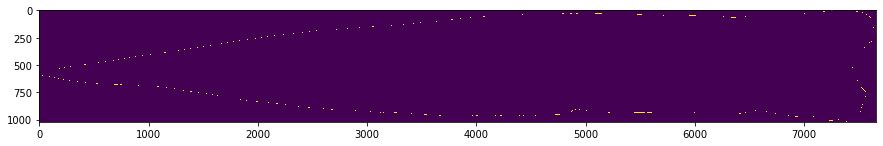

In [101]:
plt.figure(figsize=(15,3))
plt.imshow(margin)
print(margin.shape)
print(np.sum(margin>0))

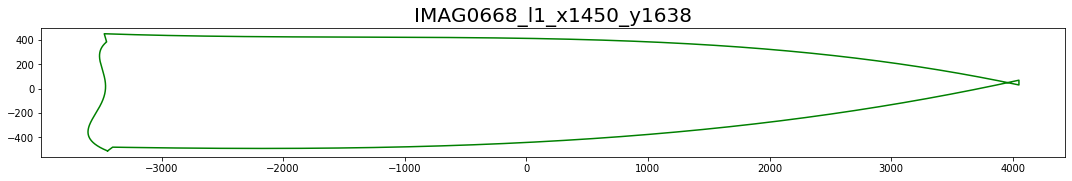

In [55]:
importlib.reload(maize)
contour, coef, rang, pred = maize.poly_margin(margin, list(blades))

plt.figure(figsize=(15,5))
plt.plot(contour[:,0], contour[:,1], '-g')
plt.axis('scaled')
plt.title(bname, fontsize=20)
plt.tight_layout()

In [112]:
def poly_margin(contour, stepsize=1):
    perimeter = 0
    for i in range(len(contour)-1):
        diff = contour[i+1][1] - contour[i][1]
        perimeter += np.sqrt(stepsize*stepsize + diff*diff)
    
    return perimeter

In [113]:
poly_margin(contour)

16443.096081612377

In [89]:
i = 2
print(rang[i][0], rang[i][-1])
print(coef[i].convert().coef)
integral = coef[i].integ(m=1, k=0)
#integral.convert().coef

print(coef[0](rang[i][-1]))
print(coef[0](rang[i][0]))

print(integral(rang[i][-1]))
print(integral(rang[i][0]))

np.abs(integral(rang[i][-1]) - integral(rang[i][0])) - np.abs(coef[i].convert().coef[0]*(rang[i][-1]-rang[i][0]))

-511.72318472743325 385.27681527256675
[-3.46068465e+03  6.73593517e-02 -1.83900883e-03  8.47059337e-07
  9.43078541e-09]
406.2720221894307
420.2319756528798
-1560052.2237204
1592860.9303596853


48679.02634860715

-3460.6846463004217


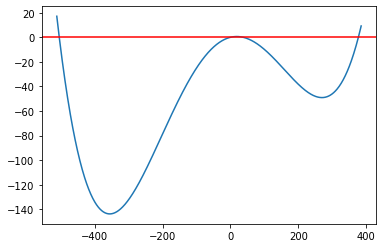

In [88]:
i = 2
print(coef[i].convert().coef[0])
plt.plot(rang[i], pred[i]-coef[i].convert().coef[0])
#i = 1
#plt.plot(rang[i], pred[i])
plt.axhline(y=0, c='r')

IMAG0001_l0_x2691_y1340
13 components
0 % reduction from input
0
IMAG0001_l1_x2403_y319
16 components
0 % reduction from input
0
IMAG0002_l0_x2061_y181
4 components
0 % reduction from input
0
IMAG0002_l1_x2024_y1450
6 components
0 % reduction from input
0
IMAG0003_l0_x1803_y254
12 components
0 % reduction from input
0
IMAG0003_l1_x1850_y1342
18 components
0 % reduction from input
0


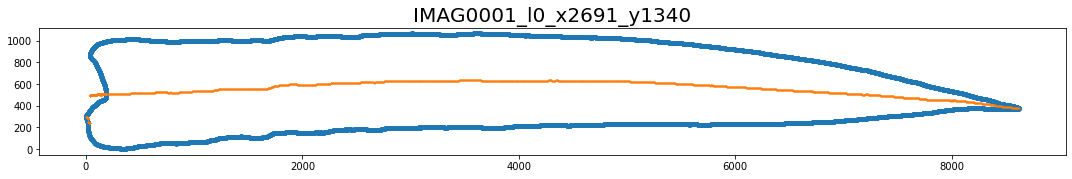

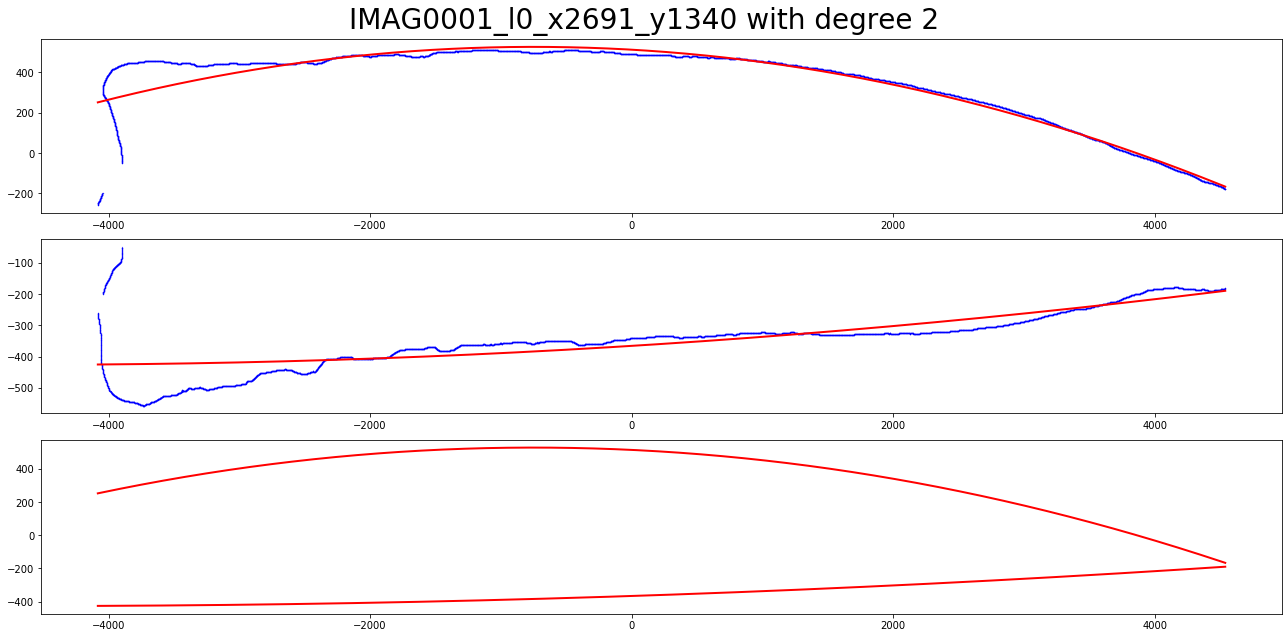

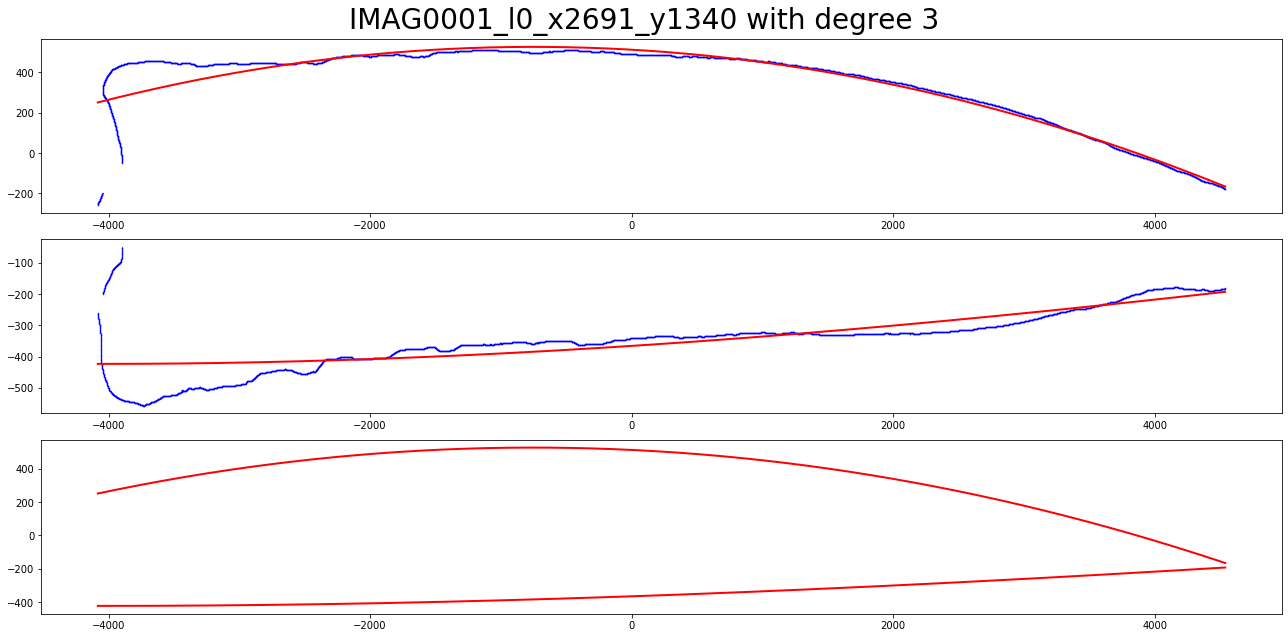

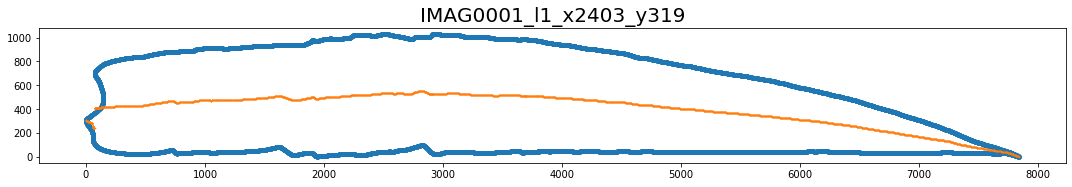

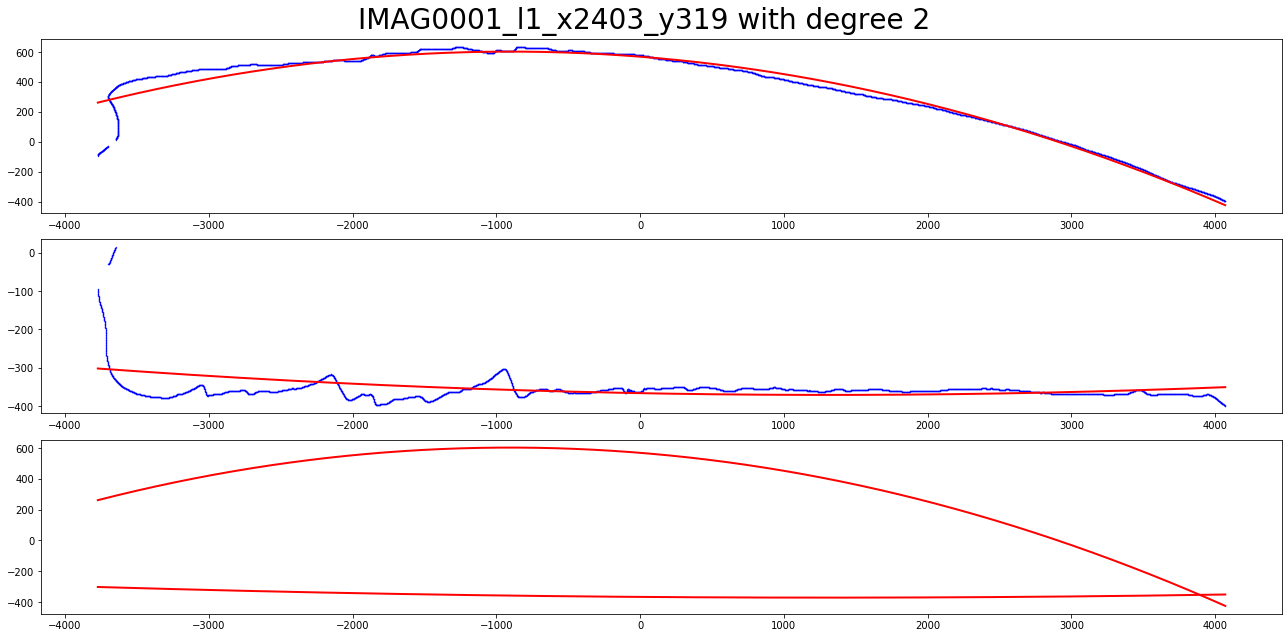

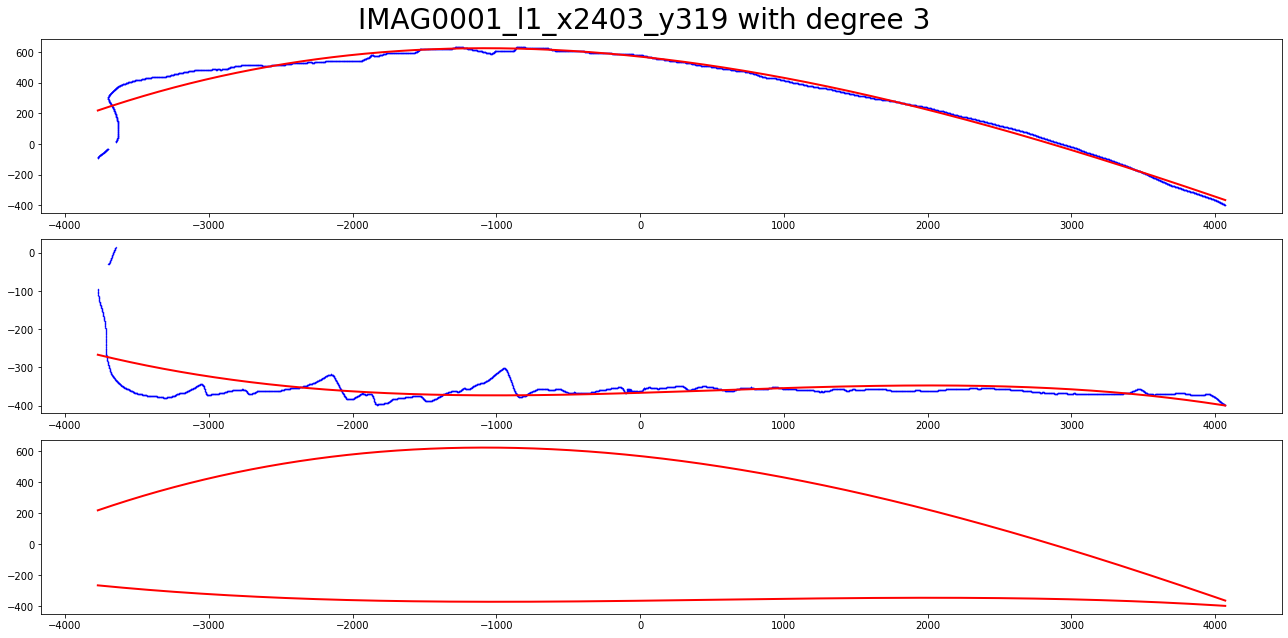

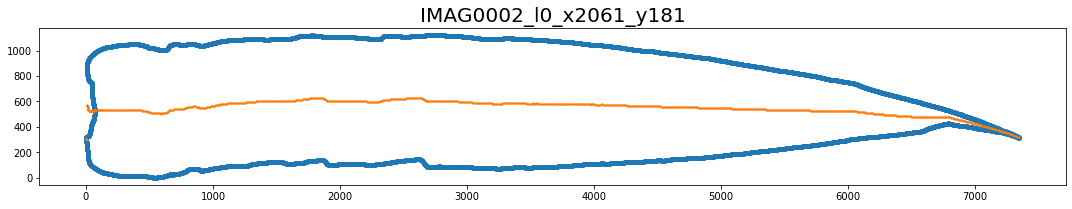

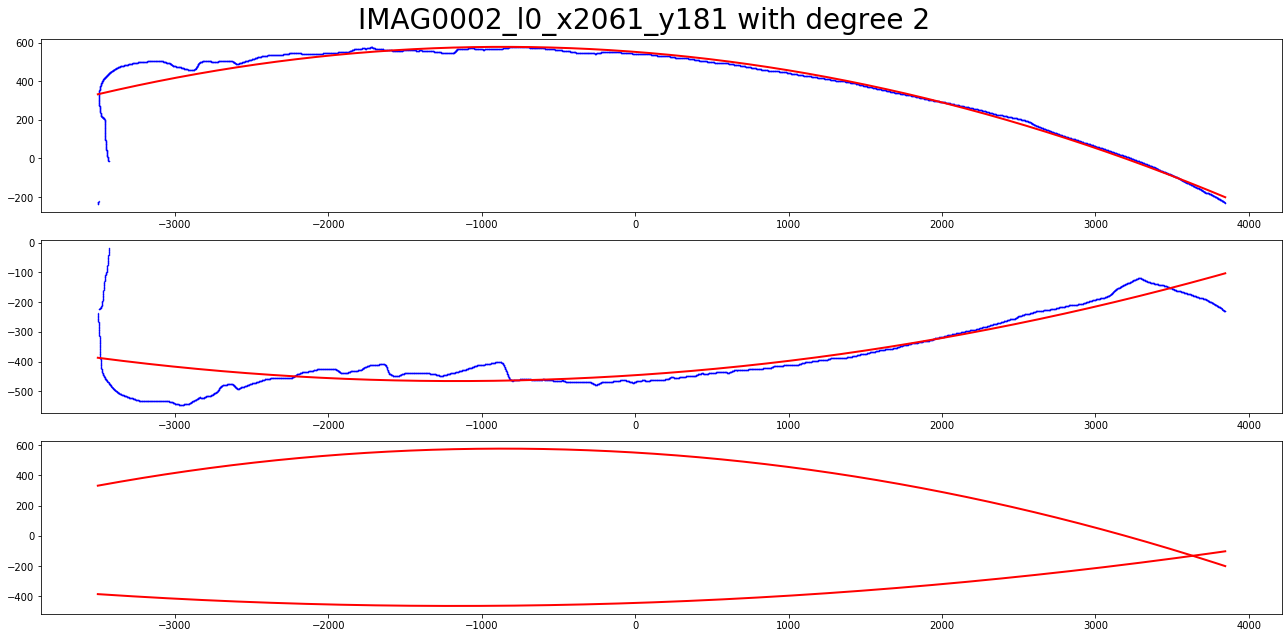

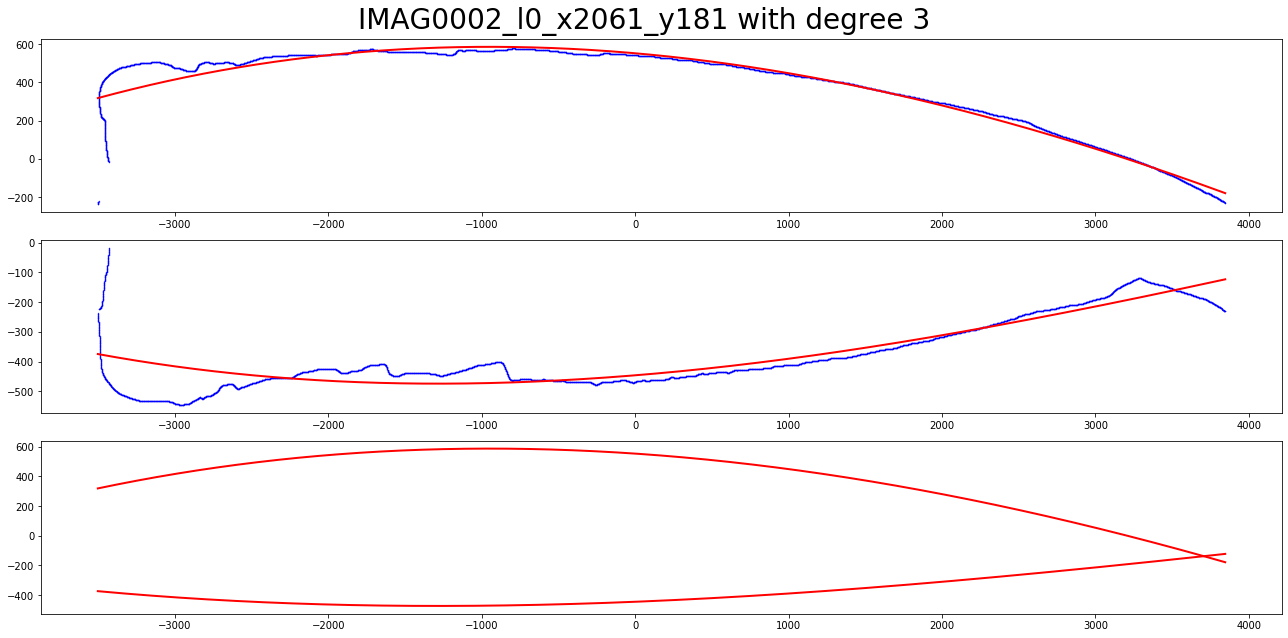

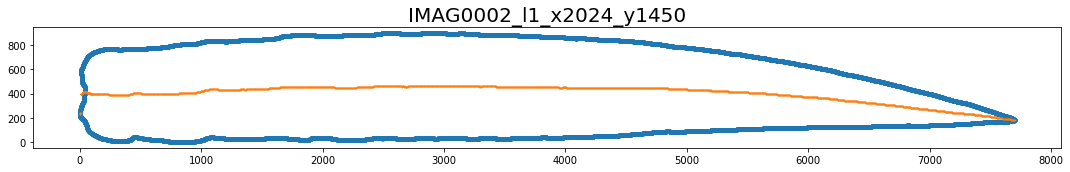

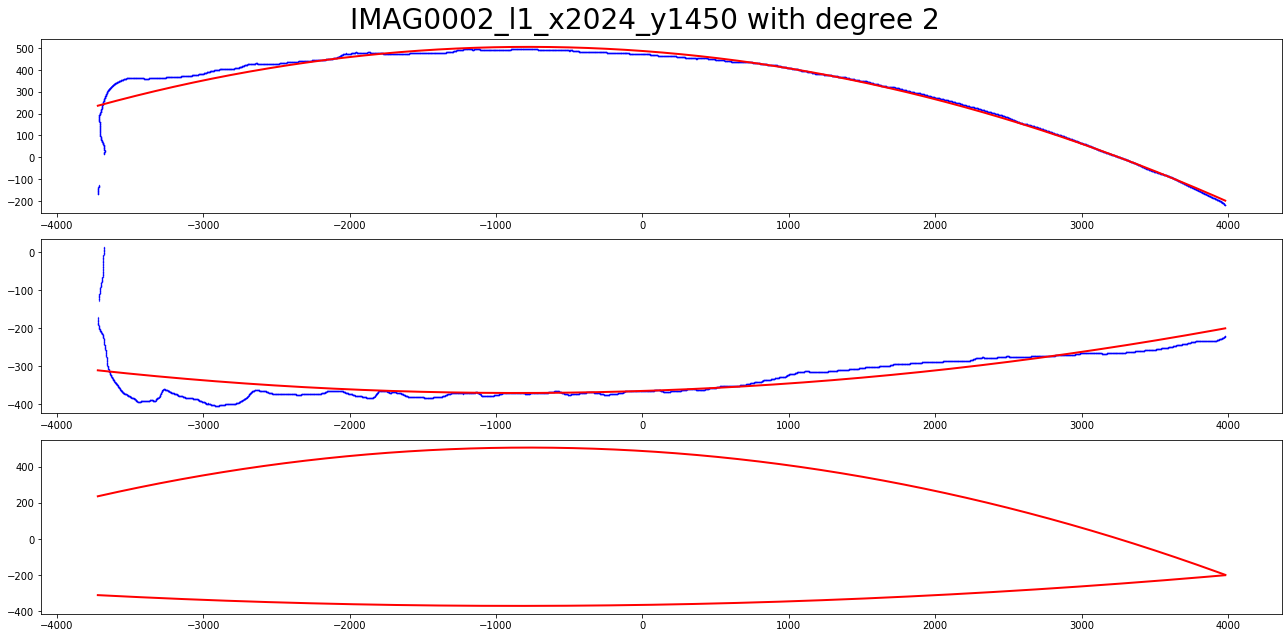

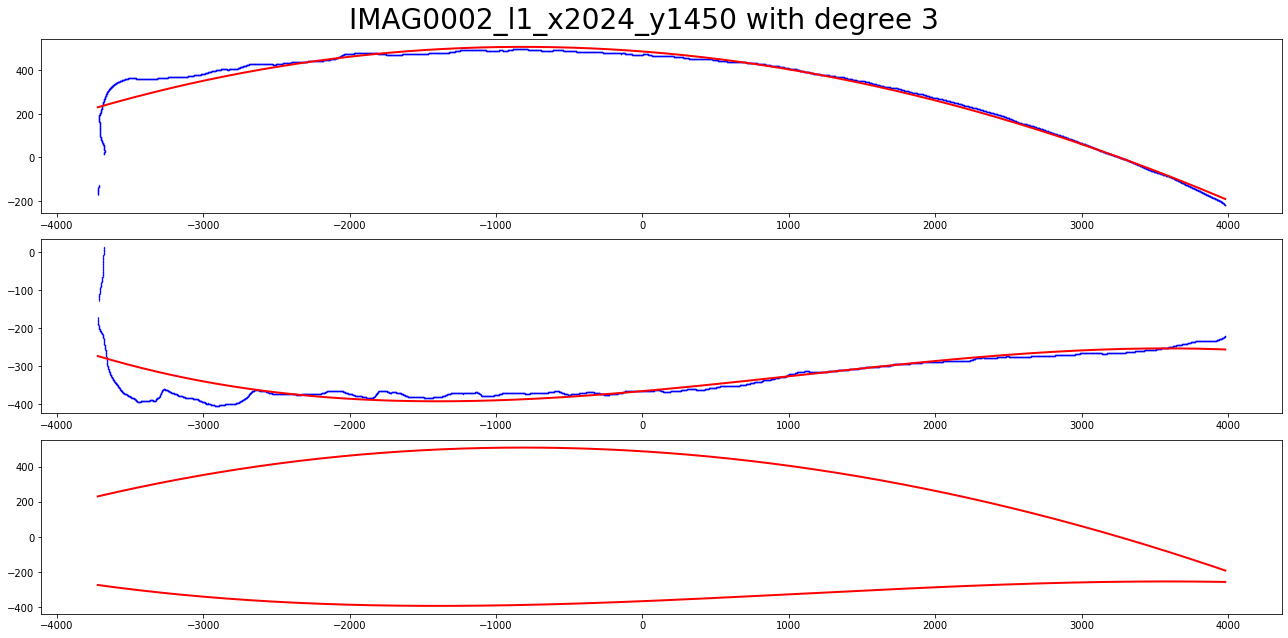

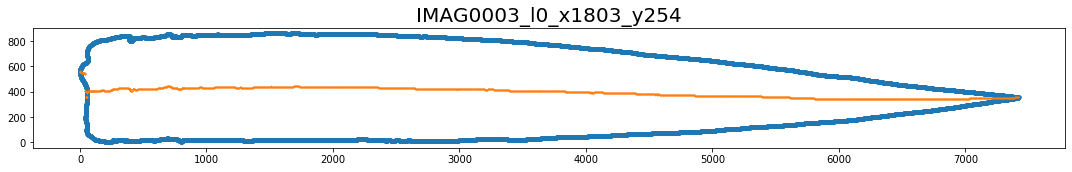

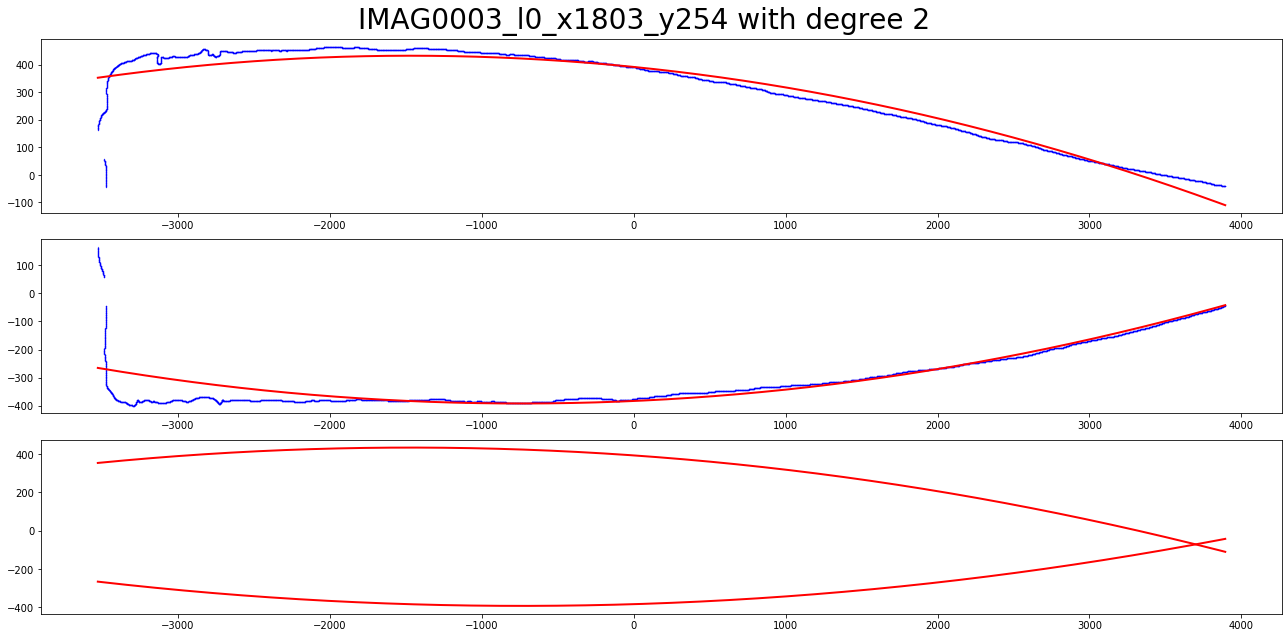

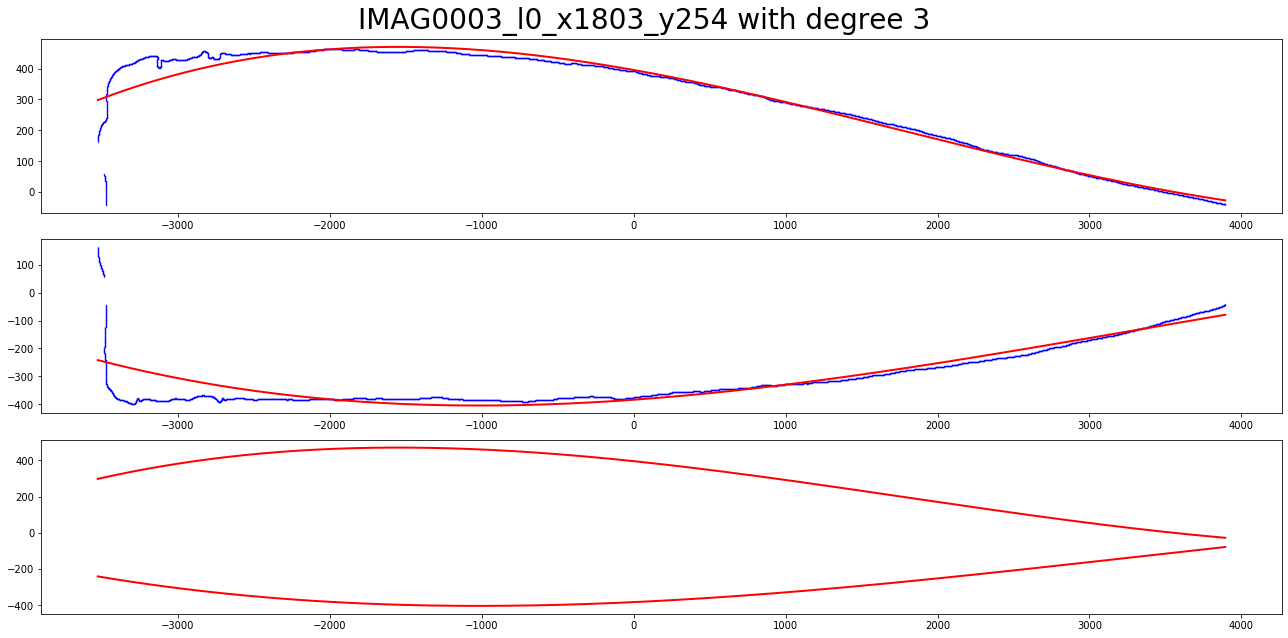

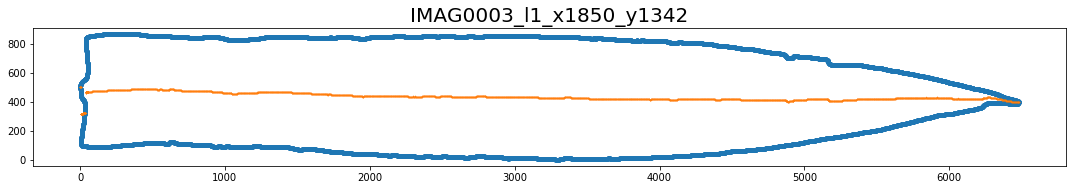

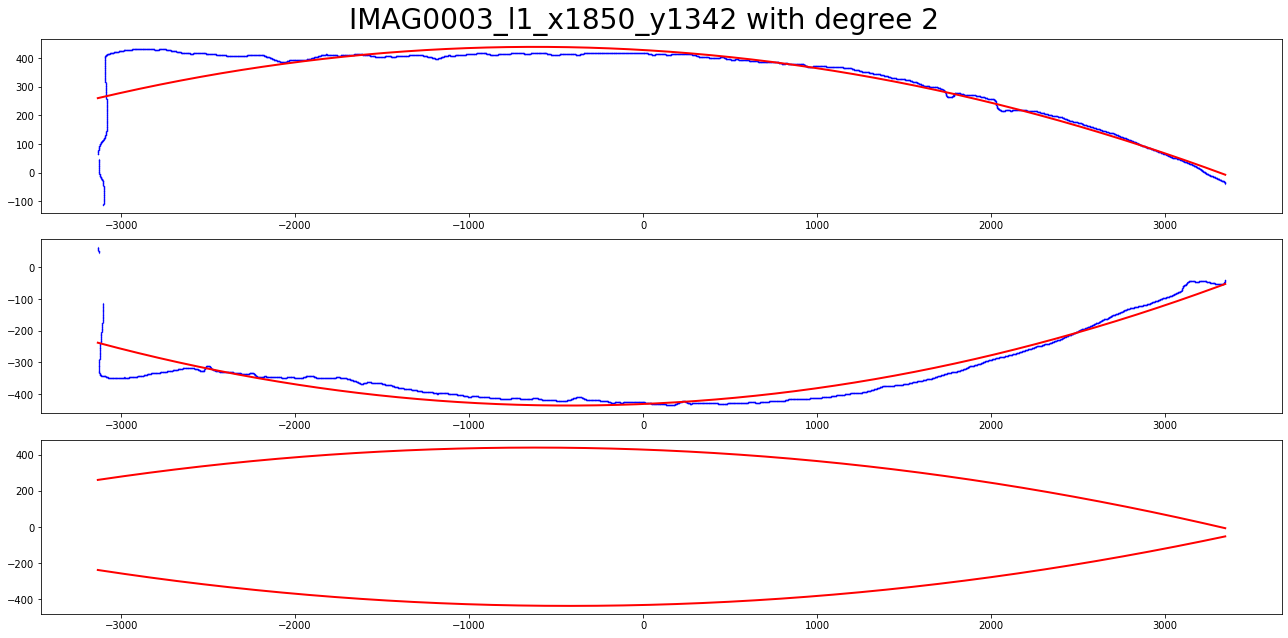

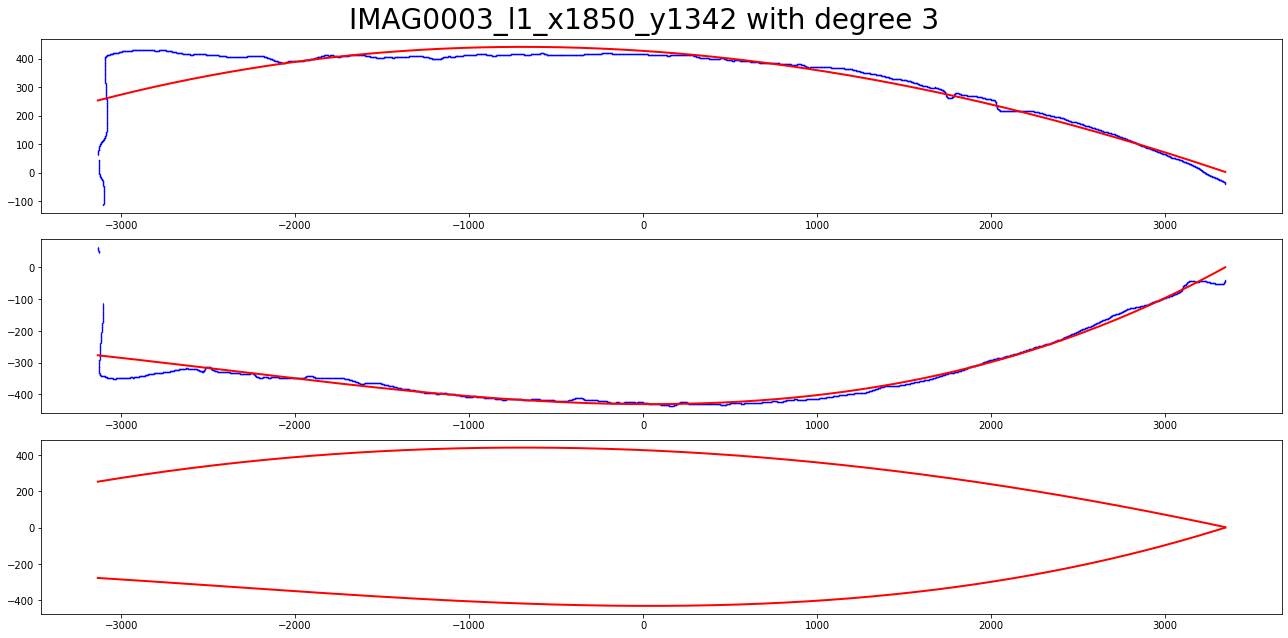

In [41]:
for tiff in tiffs:
    results = model_leaf(tiff, border, dst, leftover=0, w=write)
    Bname.append(results[0])
    Perimeter.append(results[1])
    Area.append(results[2])
    Ratio.append(results[3])
    
    R_coeff2_2.append(results[4][0][0])
    R_coeff2_1.append(results[4][0][1])
    R_coeff2_0.append(results[4][0][2])
    
    R_coeff3_3.append(results[4][1][0])
    R_coeff3_2.append(results[4][1][1])
    R_coeff3_1.append(results[4][1][2])
    R_coeff3_0.append(results[4][1][3])
    
    L_coeff2_2.append(results[5][0][0])
    L_coeff2_1.append(results[5][0][1])
    L_coeff2_0.append(results[5][0][2])
    
    L_coeff3_3.append(results[5][1][0])
    L_coeff3_2.append(results[5][1][1])
    L_coeff3_1.append(results[5][1][2])
    L_coeff3_0.append(results[5][1][3])
    
    R_length2.append(results[6][0])
    R_length3.append(results[6][1])
    
    L_length2.append(results[7][0])
    L_length3.append(results[7][1])
    
    Length2.append(results[8][0])
    Length3.append(results[8][1])

In [48]:
summary = pd.DataFrame()
summary['Label'] = Bname
summary['Perimeter'] = Perimeter
summary['Area'] = Area
summary['A vs P ratio'] = Ratio

summary['R_coeff2_2'] = R_coeff2_2
summary['R_coeff2_1'] = R_coeff2_1
summary['R_coeff2_0'] = R_coeff2_0

summary['R_coeff3_3'] = R_coeff3_3
summary['R_coeff3_2'] = R_coeff3_2
summary['R_coeff3_1'] = R_coeff3_1
summary['R_coeff3_0'] = R_coeff3_0

summary['L_coeff2_2'] = L_coeff2_2
summary['L_coeff2_1'] = L_coeff2_1
summary['L_coeff2_0'] = L_coeff2_0

summary['L_coeff3_3'] = L_coeff3_3
summary['L_coeff3_2'] = L_coeff3_2
summary['L_coeff3_1'] = L_coeff3_1
summary['L_coeff3_0'] = L_coeff3_0

summary['R_length2'] = R_length2
summary['R_length3'] = R_length3

summary['L_length2'] = L_length2
summary['L_length3'] = L_length3

summary['T_length2'] = Length2
summary['T_length3'] = Length3

summary

,Label,Perimeter,Area,A vs P ratio,R_coeff2_2,R_coeff2_1,R_coeff2_0,R_coeff3_3,R_coeff3_2,R_coeff3_1,...,L_coeff3_3,L_coeff3_2,L_coeff3_1,L_coeff3_0,R_length2,R_length3,L_length2,L_length3,T_length2,T_length3
0,IMAG0001_l0_x2691_y1340,20221,6084833,300.916522,-0.000025,-0.037136,512.562053,1.387236e-11,-0.000025,-0.037305,...,-9.027200e-11,0.000003,0.027118,-365.980632,8697.016787,8696.954012,8626.047703,8625.892767,17323.064489,17322.846780
1,IMAG0001_l1_x2403_y319,18876,5538949,293.438705,-0.000041,-0.075041,567.996103,2.385095e-09,-0.000042,-0.098793,...,-1.892738e-09,0.000003,0.011422,-366.247546,8006.508535,7999.273424,7842.712186,7846.103295,15849.220721,15845.376718
2,IMAG0002_l0_x2061_y181,17979,5679433,315.892597,-0.000035,-0.060513,551.659212,1.067519e-09,-0.000035,-0.070050,...,-9.468751e-10,0.000015,0.042065,-446.144457,7448.763206,7445.539649,7368.140963,7366.753576,14816.904169,14812.293225
3,IMAG0002_l1_x2024_y1450,17706,5122735,289.321981,-0.000031,-0.048374,486.970834,3.258919e-10,-0.000031,-0.051512,...,-2.253142e-09,0.000007,0.033846,-365.599913,7786.027826,7785.039820,7705.790409,7707.647424,15491.818236,15492.687244
4,IMAG0003_l0_x1803_y254,17116,4540247,265.263321,-0.000019,-0.055457,392.214826,3.700439e-09,-0.000020,-0.088001,...,-1.676520e-09,0.000017,0.039089,-384.010733,7459.481236,7457.157731,7442.277141,7441.036330,14901.758377,14898.194060
5,IMAG0003_l1_x1850_y1342,15340,4328560,282.174707,-0.000028,-0.035193,427.731919,7.079910e-10,-0.000028,-0.040134,...,3.722035e-09,0.000027,-0.002042,-430.939221,6521.594840,6520.507166,6515.618813,6524.600134,13037.213653,13045.107300


In [ ]:
summary.to_csv(dst + 'summary.csv', index=False)

IMAG0005_l0_x1666_y1110
19 components
0 % reduction from input
0


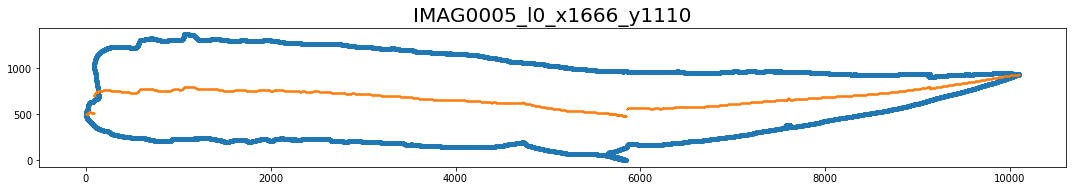

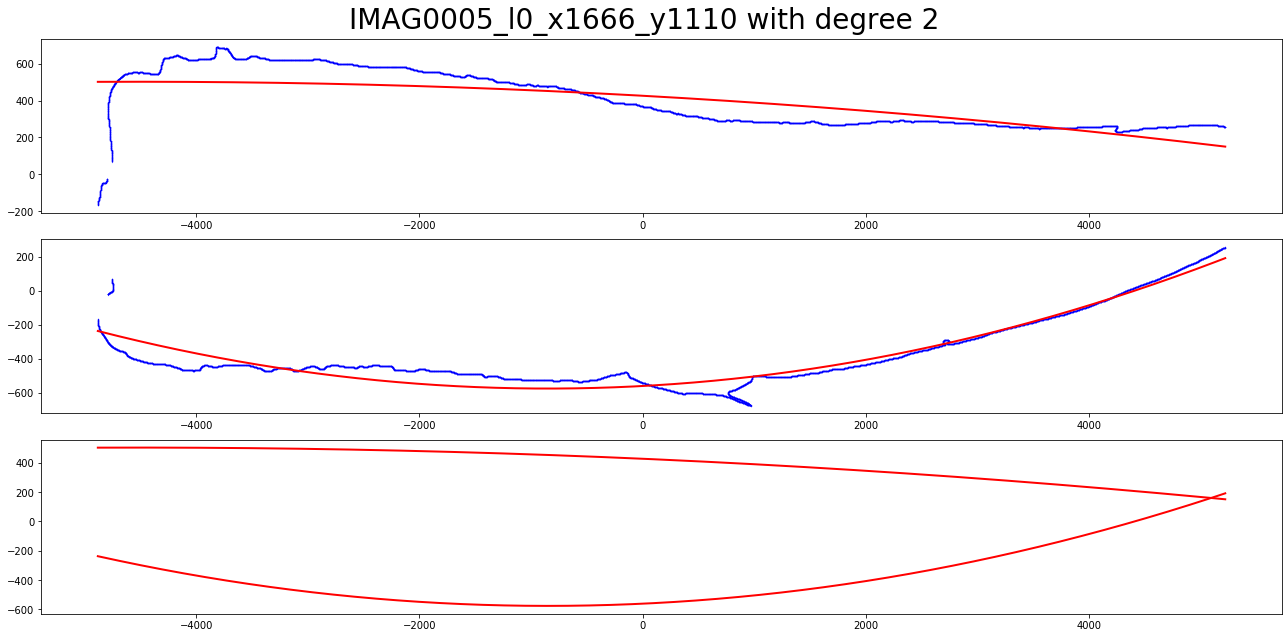

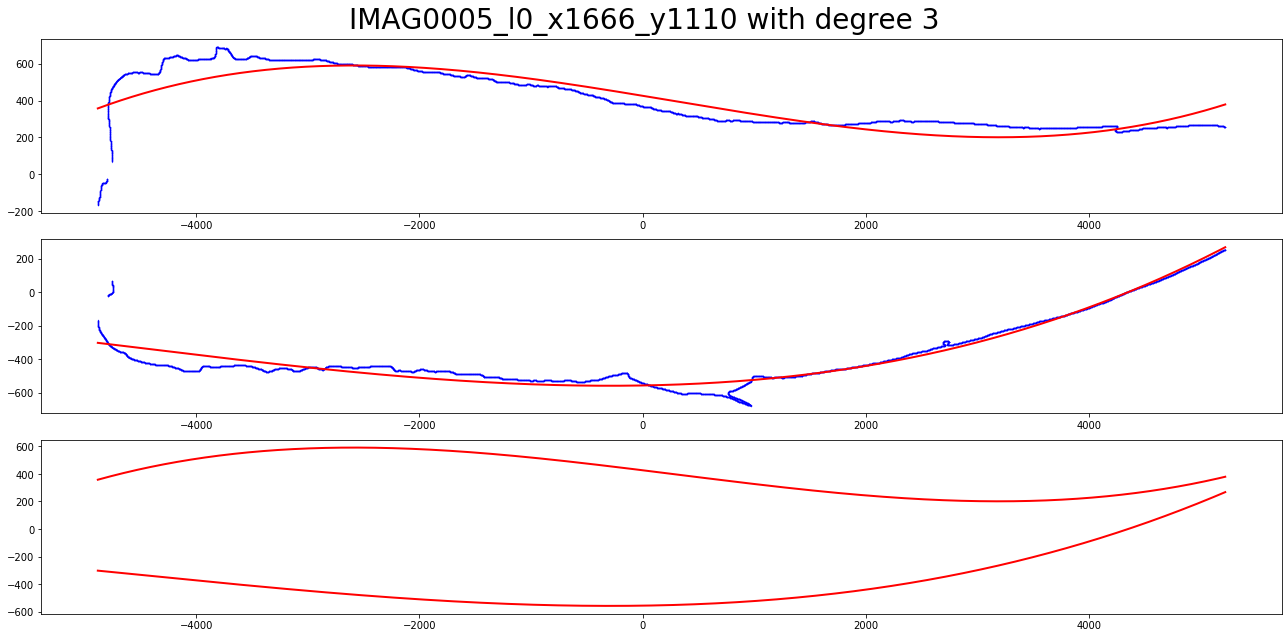

In [47]:
tiff = '/home/ejam/documents/css893/split_grayscale/IMAG0005_l0_x1666_y1110.tif'
write = True
foo = model_leaf(tiff, border, dst, leftover=0, w=write)

0 % reduction from input


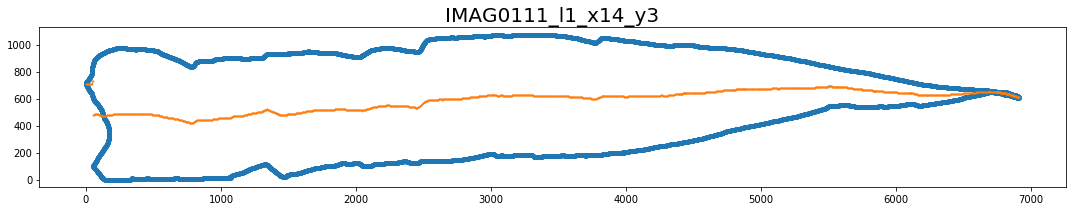

In [12]:
left, right = side_coords(box,dst,bname,w=True)

In [13]:
leftover = 0
skip = int(leftover*left.shape[0])
print(skip)
degree = 3

r_coeff, r_range, r_pred = curve_fitting(right, degree, skip)
l_coeff, l_range, l_pred = curve_fitting(left, degree, skip)

0


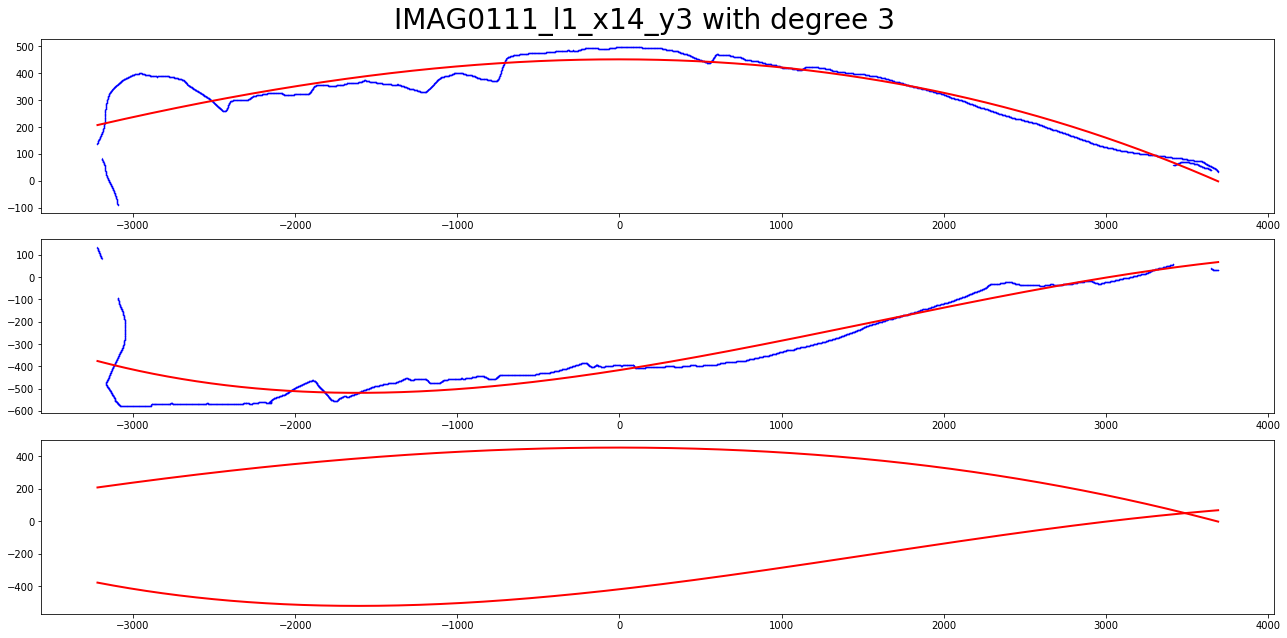

In [19]:
fig, axes = plt.subplots(3, 1, figsize=(18, 9))

fig.suptitle(bname+' with degree '+str(degree), fontsize=28)

axes[0].plot(right[skip:,0], right[skip:,1], '.b', ms=0.5)
axes[0].plot(r_range, r_pred, 'r', lw=2)

axes[1].plot(left[skip:,0], left[skip:,1],'.b',  ms=0.5)
axes[1].plot(l_range, l_pred, 'r', lw=2)

axes[2].plot(r_range,r_pred, 'r', lw=2)
axes[2].plot(l_range,l_pred, 'r', lw=2)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

plt.savefig(dst+bname+'_deg'+str(degree)+'.jpg', dpi=150, optimize=True, format='jpg')

In [ ]:
r_length = curve_length(r_range, r_pred)
l_length = curve_length(l_range, l_pred)

In [ ]:
lengths = np.sqrt(np.sum(np.diff(r_curve, axis=0)**2, axis=1)) # Length between corners
total_length = np.sum(lengths)
print(total_length)

In [ ]:
box = clean_zeroes(box)
if box.shape[0] < box.shape[1]:
    print('T!')
    box = box.T

In [ ]:
box.shape

In [ ]:
coords = tiff2coords(box, center=False)
tip = coords[coords[:,0] == coords.max(axis=0)[0]]
base = coords[coords[:,0] == coords.min(axis=0)[0]]
flip = False

if tip.shape[0] > base.shape[0]:
    coords[:,0] = tip[0,0] - coords[:,0]
    flip = True

In [ ]:
hist, bins = np.histogram(coords[:,0], bins=box.shape[0], range=(0,box.shape[0]))
print(hist[:30], bins, sep='\n\n')

In [ ]:
center_side = np.empty((coords.shape[0],  2 ), dtype=np.float64, order='C')

k = 0
for i in range(box.shape[0]):
    left,right = 0,0
    for j in range(box.shape[1]):
        if box[i,j]:
            left = j
            break
    for j in range(box.shape[1]-1, 0, -1):
        if box[i,j]:
            right = j
            break
    for j in range(hist[i]):
        center_side[k,:] = i,0.5*(left+right) 
        k += 1
if flip:
    center_side = np.flip(center_side, 0)
    center_side[:,0] = tip[0,0] - center_side[:,0]

In [ ]:
plt.figure(figsize=(15,3))
plt.plot(coords[:,0],coords[:,1], '.')
plt.plot(center_side[:,0], center_side[:,1], '.', ms=0.5)
plt.axis('scaled')
plt.title(bname, fontsize=20)
plt.tight_layout()
plt.savefig(dst+bname+'_contour.jpg', dpi=100, optimize=True, format='jpg')

In [ ]:
ind = np.lexsort((coords[:,1], coords[:,0]))
coords = coords[ind, :]

In [ ]:
print(coords[-50:,],'\n\n',center_side[-50:,])

In [ ]:
l_mask = coords[:, 1] <= center_side[:, 1]
r_mask = coords[:, 1] >= center_side[:, 1]

In [ ]:
l_mask[-50:]

In [ ]:
l_mask = coords[:, 1] <= center_side[:, 1]
r_mask = coords[:, 1] >= center_side[:, 1]
    
origin = -1*np.mean(coords, axis=0)
coords = np.add(coords, origin)
    
left,right = coords[l_mask], coords[r_mask]

In [ ]:
print(right[0,0], right[-1,0])

In [ ]:
plt.plot()

In [ ]:
for tiff in tiffs:
    bname, perimeter, area, ratio coords = compute_perimeter(tiff, ssrc, dst, border, cutoff)
    print('////////////////////////////')
    Bname.append(bname)
    Perimeter.append(perimeter)
    Area.append(area)
    Ratio.append(ratio)    

In [ ]:
summary[summary['A vs P ratio'] == min(Ratio)]

In [ ]:
leaf = tf.imread(lsrc+l_name)
leaf[leaf > 0] = 1
tf.imwrite(dst+'foo0.tif', leaf, photometric='minisblack', compress=5)
plt.figure(figsize=(40,12))
plt.imshow(leaf, cmap=plt.cm.gray)
plt.axis('off')